# Supplementary Figure 6: Spatial residuals

The expected model residuals (difference in total expected less total observed reports), stratified by weekdays and weekends. The location of the radar is marked in yellow to highlight the lack of range dependence in errors. Note the lighter cells west of Brisbane and north-west of the radar site perhaps showing under-prediction over the highway to Toowoomba, particularly on weekends.

## Package imports

In [1]:
additional_package_lib <- "/scratch/w42/ig1052/rlibs"

suppressPackageStartupMessages({
  library(tidyverse)
  library(ozmaps, lib.loc = additional_package_lib)
  library(patchwork)
  library(sf)
  library(scico)
})

## Utility functions

In [2]:
calculate_errors_plot <- function(tib){
  # Create the spatial errors plot for a given (filtered) data frame
  #
  # Inputs:
  #  tib  tibble
  #       assumed to be a tibble with posterior predictive samples
  # 
  # Outputs:
  #  _     ggplot object
  #        spatial expected errors with the radar marked in yellow

  # processing  
  process_tib <- tib %>% 
  # grouping by bins
    group_by(x_bins, y_bins) %>%
    # ensuring report is integer
    mutate(report = as.integer(as.character(report))) %>%
    # number of reports in each bin in each posterior sample
    summarise(across(c(report, starts_with("post_pred")), sum), .groups = "drop") %>%
    # rowwise bin to take expected number of reports across all the posterior samples
    rowwise() %>%
    mutate(exp_num_reports = mean(c_across(starts_with("post_pred")))) %>%
    # dropping now redundant posterior predictive samples columns
    select(-starts_with("post_pred")) %>%
    # calculating expected error
    mutate(diff = exp_num_reports - report)
  
  # plotting
  process_tib %>%
    ggplot() + 
    # tile plot of the error
    geom_tile(aes(x = x_bins, y = y_bins, fill = diff)) +
    # colour bar
    scale_fill_scico(palette = "berlin", 
                     name = "Expected\nresiduals\n[reports]", 
                     midpoint = 0, 
                     breaks = seq(-4.5, 2.5, by = 1), 
                     guide = guide_colorsteps(), 
                     limits = c(-4.5, 2.5)) +
    # adding borders
    geom_sf(data = ozmap_states, color = "blue", fill = NA, linewidth = 1) + 
    # scaling for map
    coord_sf() +
    # focussing on study area
    xlim(c(min(post_report_cv$x_bins) - 0.25, max(post_report_cv$x_bins) + 0.25)) + 
    ylim(c(min(post_report_cv$y_bins) - 0.25, max(post_report_cv$y_bins) + 0.25)) +
    # radar location
    geom_point(aes(x = x, y = y), data = tibble(x = 153.24, y = -27.718), color = "yellow", size = 5) + 
    # labelling 
    xlab("Longitude [degrees east]") + 
    ylab("Latitude [degrees south]") +
    # size
    theme_gray(base_size = 18) +  
    # stretch legend
    theme(legend.key.height = unit(2, "cm"))
}

## Reading in data

In [3]:
# reading in posterior predictive samples from cross validation run
post_report_cv <- readRDS(paste0("/g/data/w42/ig1052/bayesian_paper_data/model_eval/",
                                 "hail_trans_std_mesh_report_trans_std_dens_yjwide_gamma/",
                                 "results/hail_trans_std_mesh_report_trans_std_dens_yjwide_",
                                 "gamma_posterior_predictive_samples_cv.rds"))

## Plotting

In [4]:
# weekend errors
p1 <- post_report_cv %>%
  filter(weekend == "weekend") %>%
  calculate_errors_plot() +
  # labelling appropriately
  ggtitle("Weekend expected model residuals") 

# weekday errors
p2 <- post_report_cv %>%
  filter(weekend == "weekday") %>% 
  calculate_errors_plot() +
  # labelling appropriately
  ggtitle("Weekend expected model residuals")

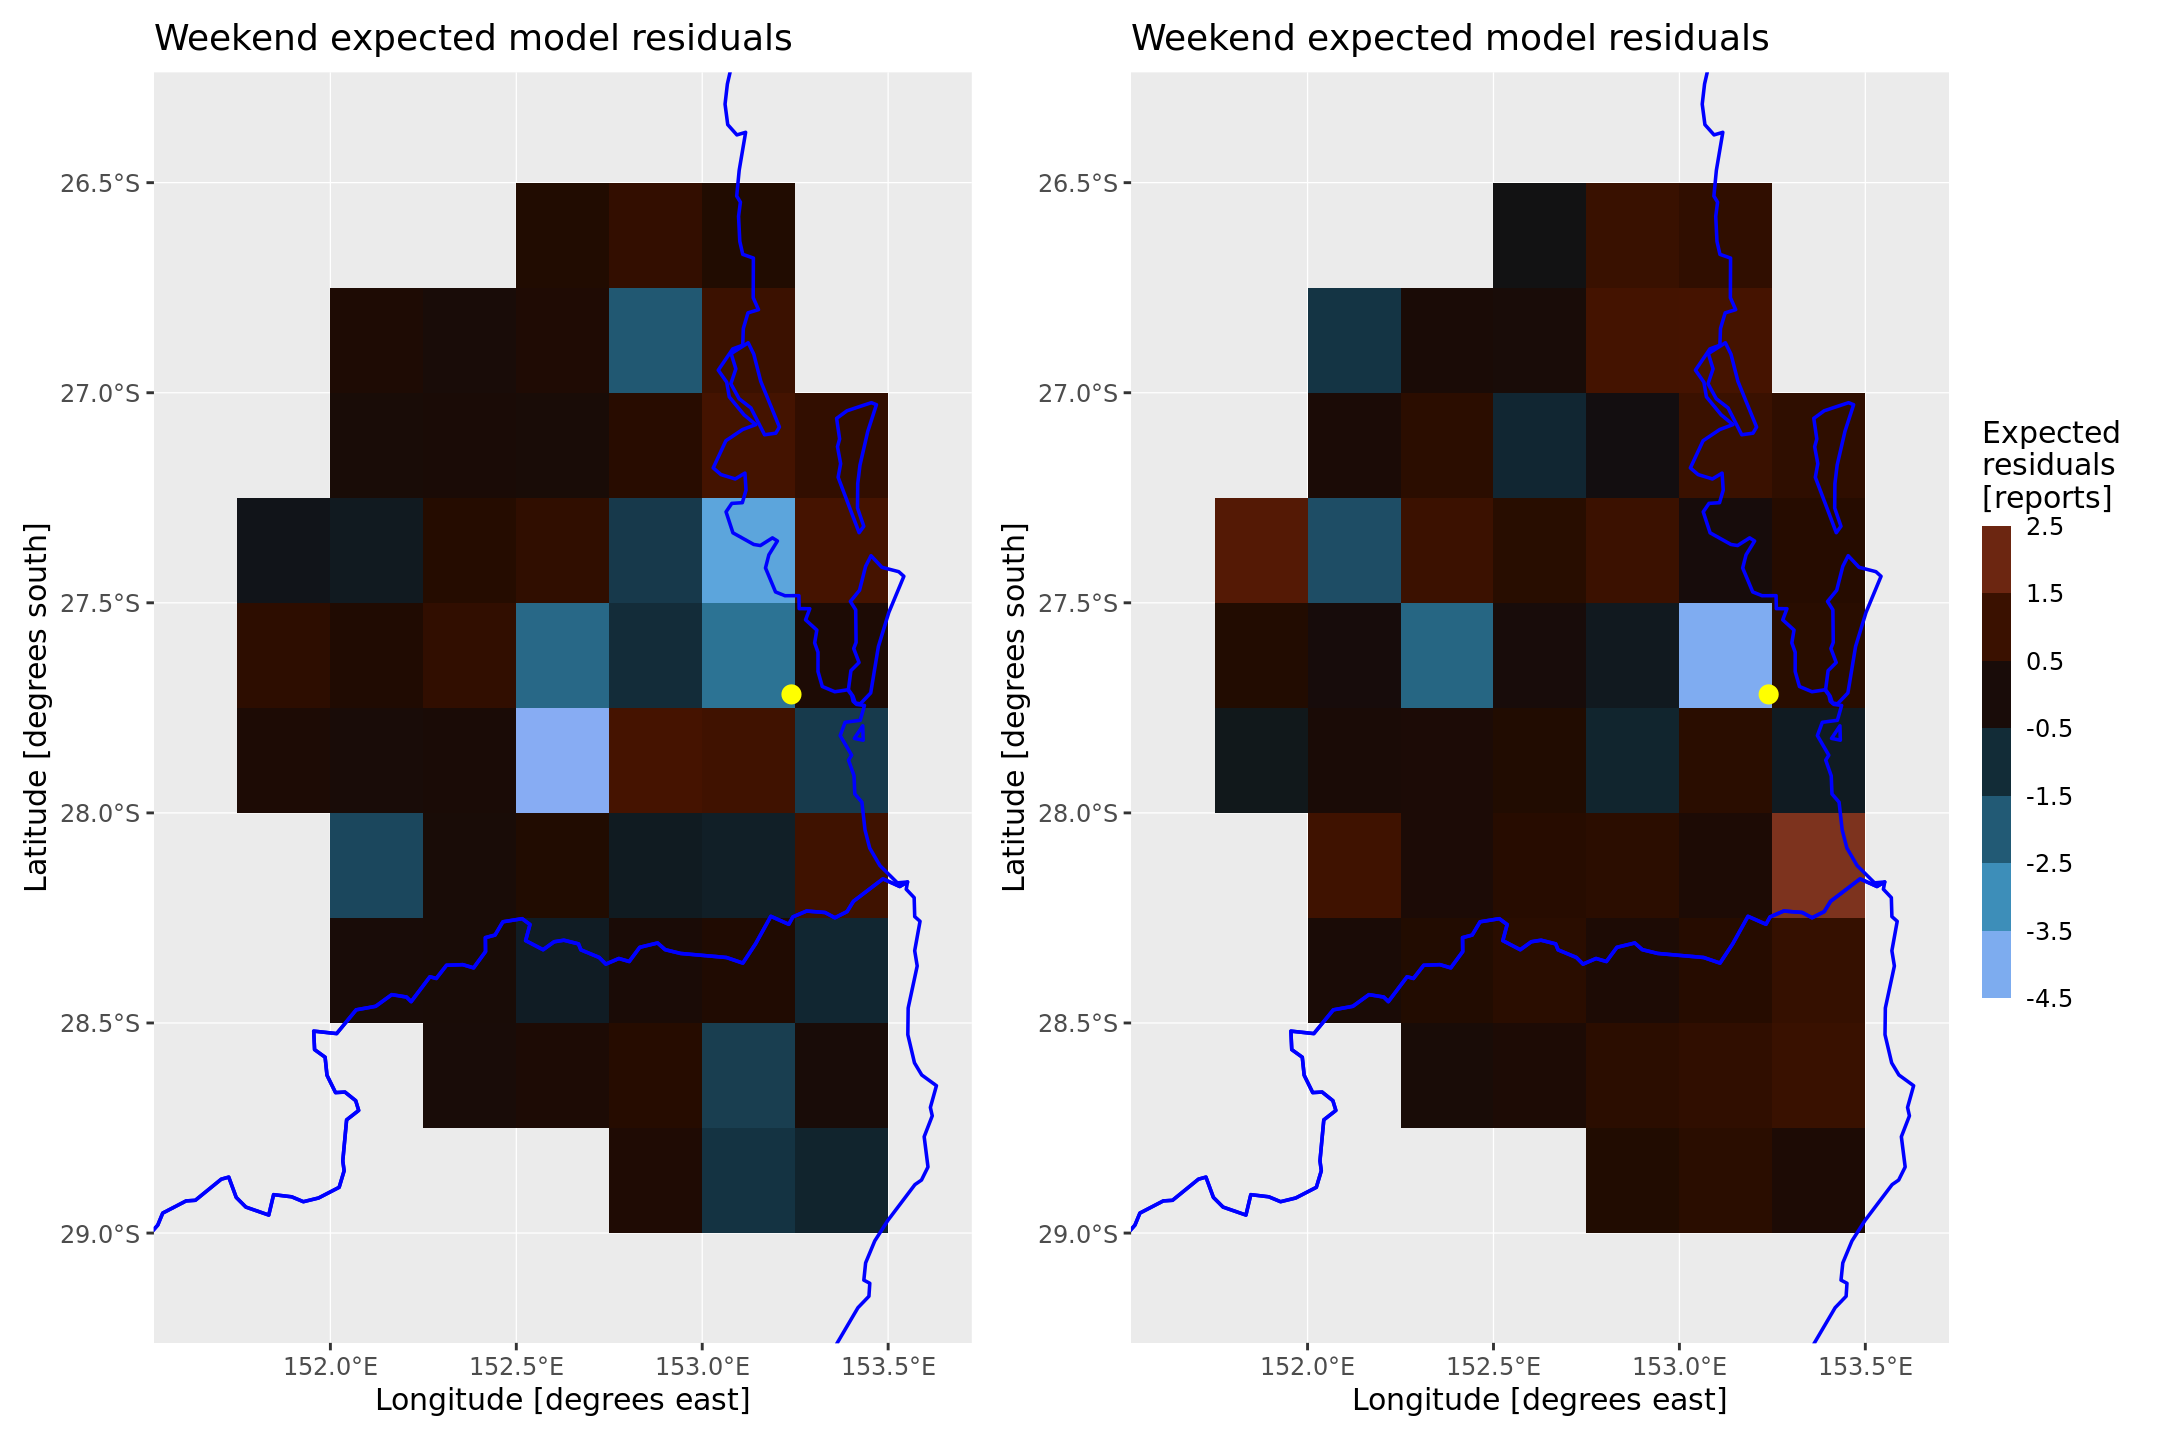

In [5]:
# plot size
options(repr.plot.height = 12, repr.plot.width = 18)

# plots side by side
p1 + p2 + plot_layout(guides = "collect")